# Facial Recognition Classification

In [ ]:
#Checking whether using GPU or not
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

In [1]:
import pandas as pd
import numpy as np
import cv2
data_path = 'data.csv'
image_size=(48,48)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces, emotions = load_data(data_path)

### A sample face

Emotion Labels [1 0 0 0 0 0]


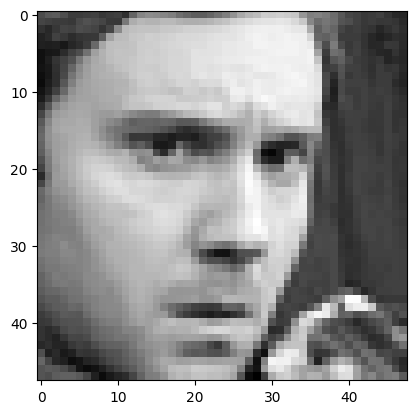

In [2]:
import matplotlib.pyplot as plt

ind = 0
f = faces[ind, :,:,0]
print('Emotion Labels', emotions[ind,:])
plt.imshow(f, cmap='gray')

### Process

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import keras
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

In [4]:
x_train, x_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.1, random_state=2020)
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
print(faces.shape)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

(23744, 48, 48, 1)
x_train shape: (21369, 48, 48, 1) y_train shape: (21369, 6)
x_val shape: (2375, 48, 48, 1) y_val shape: (2375, 6)


In [5]:
# Data augmentation
augmented_train = []
augmented_train_label = []
for img, label in zip(x_train, y_train):
    image_array = image.img_to_array(img)
    
    augmented_train.append(image_array)
    augmented_train_label.append(label)
    
    flip_hr=iaa.Fliplr(p=1.0)
    flip_hr_image= flip_hr.augment_image(img)
    image_array = image.img_to_array(flip_hr_image)
    augmented_train.append(image_array)
    augmented_train_label.append(label)
    
    
    flip_vr=iaa.Flipud(p=1.0)
    flip_vr_image= flip_vr.augment_image(img)
    image_array = image.img_to_array(flip_vr_image)
    augmented_train.append(image_array)
    augmented_train_label.append(label)
    
    flip_twice= flip_vr.augment_image(flip_hr_image)
    image_array = image.img_to_array(flip_twice)
    augmented_train.append(image_array)
    augmented_train_label.append(label)
    

<Figure size 640x480 with 0 Axes>

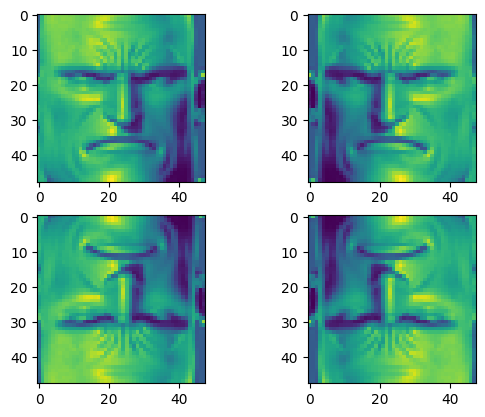

In [6]:
# Check the augmented picture set
plt.figure()

# Subplot(r,c) provide the no. of rows and columns
fig, axarr = plt.subplots(2,2)

# Use the created array to output your multiple images
axarr[0,0].imshow(augmented_train[0])
axarr[0,1].imshow(augmented_train[1])
axarr[1,0].imshow(augmented_train[2])
axarr[1,1].imshow(augmented_train[3])

In [7]:
# Making the list into numpy array
train_images = np.asarray(augmented_train,dtype='float32')
train_label = np.asarray(augmented_train_label,dtype='float32')

In [8]:
x_train = train_images
y_train = train_label
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

x_train shape: (85476, 48, 48, 1) y_train shape: (85476, 6)
x_val shape: (2375, 48, 48, 1) y_val shape: (2375, 6)


In [37]:
#Duplicating the grayscale to RGB (3 Channels) for ResNet and Other state of the art architecture
#Not used

# rgb_batch = np.repeat(faces[...], 3, -1)    
# print(rgb_batch.shape)

# x_train, x_val, y_train, y_val = train_test_split(rgb_batch, emotions, test_size=0.2, random_state=2020)
# x_train = x_train.astype('float32') / 255
# x_val = x_val.astype('float32') / 255
# print(faces.shape)
# print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
# print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

(23744, 48, 48, 3)
(23744, 48, 48, 1)
x_train shape: (18995, 48, 48, 3) y_train shape: (18995, 6)
x_val shape: (4749, 48, 48, 3) y_val shape: (4749, 6)


In [9]:
#Current second best but short
# model = tf.keras.Sequential([
#     layers.Conv2D(64, (5, 5), input_shape=[48, 48, 1]),
#     layers.MaxPool2D((3,3), strides=2),
#     layers.Conv2D(64, (5, 5)),
#     layers.MaxPool2D((3,3), strides=2),
#     layers.Conv2D(128, (4, 4)),
#     layers.Flatten(),
#     layers.Dense(3072, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(6, activation='softmax')
# ])

In [9]:
# Current best model
model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(6, activation='softmax')
])

In [12]:
# Resnet trial
# Not used
# base_model = tf.keras.applications.ResNet50(input_shape=(48, 48, 3), include_top=False)
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [11]:
# Compiling model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Setting up the early stopper and checkpointer

MODELPATH = r"model_aug.h5"
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [13]:
# Running the model
history = model.fit(x_train, y_train, batch_size=64, verbose=1, validation_data = (x_val, y_val), epochs=300, callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Epoch 1/300
1336/1336 [==============================] - ETA: 0s - loss: 1.6742 - accuracy: 0.3009
Epoch 1: val_loss improved from inf to 1.80978, saving model to model_final_aug.h5
1336/1336 [==============================] - 125s 77ms/step - loss: 1.6742 - accuracy: 0.3009 - val_loss: 1.8098 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 2/300
1336/1336 [==============================] - ETA: 0s - loss: 1.4453 - accuracy: 0.4093
Epoch 2: val_loss improved from 1.80978 to 1.29958, saving model to model_final_aug.h5
1336/1336 [==============================] - 43s 32ms/step - loss: 1.4453 - accuracy: 0.4093 - val_loss: 1.2996 - val_accuracy: 0.4808 - lr: 0.0010
Epoch 3/300
1336/1336 [==============================] - ETA: 0s - loss: 1.2907 - accuracy: 0.4823
Epoch 3: val_loss improved from 1.29958 to 1.22041, saving model to model_final_aug.h5
1336/1336 [==============================] - 43s 32ms/step - loss: 1.2907 - accuracy: 0.4823 - val_loss: 1.2204 - val_accuracy: 0.4817 - lr: 0.0010
E

Epoch 27/300
1335/1336 [============================>.] - ETA: 0s - loss: 0.7029 - accuracy: 0.7342
Epoch 27: val_loss did not improve from 0.87599
1336/1336 [==============================] - 43s 32ms/step - loss: 0.7027 - accuracy: 0.7342 - val_loss: 0.9112 - val_accuracy: 0.6754 - lr: 8.1000e-04
Epoch 27: early stopping


In [14]:
# Save the final model
model.save("model_final_aug.h5")

# Start from here if wanted to check the result only

In [1]:
# Importing necessary function to check the result
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# Loading the data
data_path = 'data.csv'
image_size=(48,48)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces, emotions = load_data(data_path); 

x_train, x_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.1, random_state=2020)
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
print(faces.shape)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

(23744, 48, 48, 1)
x_train shape: (21369, 48, 48, 1) y_train shape: (21369, 6)
x_val shape: (2375, 48, 48, 1) y_val shape: (2375, 6)


In [3]:
# Loading the best model based on validation loss
model = tf.keras.models.load_model('model_aug.h5')
# Load 'model.h5' if wanted to check the model without data augmentation

In [19]:
# Loading the final model
# Has a slightly higher accuracy but higher loss too
model = tf.keras.models.load_model('model_final_aug.h5')
# Load 'model_final.h5' if wanted to check the model without data augmentation

In [4]:
# Print out some evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Print the loss and accuracy of the test data
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
label_names = ['1','2','3','4','5','6']
# Print the confusion matrix
predict_x=model.predict(x_val) 

y_predict=np.argmax(predict_x,axis=1)
y_real=y_val.argmax(axis=1)

print(classification_report(y_real, y_predict, target_names = label_names))

Test loss: 0.8763631582260132
Test accuracy: 0.6749473810195923
              precision    recall  f1-score   support

           1       0.65      0.54      0.59       399
           2       0.75      0.14      0.23        44
           3       0.48      0.42      0.45       421
           4       0.87      0.87      0.87       711
           5       0.53      0.75      0.62       464
           6       0.79      0.70      0.74       336

    accuracy                           0.67      2375
   macro avg       0.68      0.57      0.58      2375
weighted avg       0.69      0.67      0.67      2375



## Facial expression data is modified from https://www.kaggle.com/c/3364
